# Data Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm


## Load the new dataset

In [2]:

file_path = "D:\\4DATA\\SEMESTER2\\PI\\DATASET\\mmwaves.csv"

# Load the dataset without setting an index
dataset = pd.read_csv(file_path, index_col=['run_num', 'seq_num'])
dataset.head() 

abstractSignalStr   latitude  longitude  movingSpeed  \
run_num seq_num                                                         
1       1.0                      2  44.975314 -93.259316     0.094889   
        2.0                      2  44.975311 -93.259311     0.876634   
        3.0                      2  44.975305 -93.259292     2.225798   
        4.0                      2  44.975293 -93.259258     3.180726   
        5.0                      2  44.975278 -93.259214     3.751234   

                 compassDirection  nrStatus  lte_rssi  lte_rsrp  lte_rsrq  \
run_num seq_num                                                             
1       1.0                   150         2     -61.0       -94     -14.0   
        2.0                   117         2     -61.0       -94     -14.0   
        3.0                   113         2     -61.0       -94     -14.0   
        4.0                   114         2     -59.0       -95     -16.0   
        5.0                   115         2     -59.0       -95     -16.0   

                    lte_rssnr  nr_ssRsrp  nr_ssRsrq  nr_ssSinr  Throughput  \
run_num seq_num                                                              
1       1.0      2.147484e+09        0.0        0.0        0.0          78   
        2.0      2.147484e+09        0.0        0.0        0.0         117   
        3.0      2.147484e+09        0.0        0.0        0.0         110   
        4.0      2.147484e+09        0.0        0.0        0.0         108   
        5.0      2.147484e+09        0.0        0.0        0.0         100   

                 mobility_mode  trajectory_direction  tower_id  
run_num seq_num                                                 
1       1.0                  0                     1        16  
        2.0                  0                     1        16  
        3.0                  0                     1        16  
        4.0                  0                     1        16  
        5.0                  0                     1        16

In [3]:
dataset=dataset[["Throughput"]]
dataset.head(10)

Throughput
run_num seq_num            
1       1.0              78
        2.0             117
        3.0             110
        4.0             108
        5.0             100
        6.0             124
        7.0             109
        8.0             108
        9.0              87
        10.0            116

In [4]:
max_throughput = dataset["Throughput"].max()
min_throughput = dataset["Throughput"].min()
print(f'Max throughput: {max_throughput}')
print(f'Min throughput: {min_throughput}')

Max throughput: 1920
Min throughput: 0


# Data Scaling

In [5]:
# Min-Max Scaling
dataset=(dataset-dataset.min())/(dataset.max()-dataset.min())
dataset.head(10)

Throughput
run_num seq_num            
1       1.0        0.040625
        2.0        0.060937
        3.0        0.057292
        4.0        0.056250
        5.0        0.052083
        6.0        0.064583
        7.0        0.056771
        8.0        0.056250
        9.0        0.045312
        10.0       0.060417

##  Create Train-Test Sets

In [6]:
# split function into sequences
def multistep_split(seq, n_steps_in, n_steps_out):
    X = list()
    y = list()
    for i in range(len(seq)):
        # pattern end
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(seq):
            break
        seq_x = seq[i:end_ix]
        seq_y = seq[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
# separately splits runs into sequences
run_max=dataset.index.max()[0]
seconds_in = 20
seconds_out = 10
X_list = list()
y_list = list()
for run_num in range(1, run_max+1):
    run = dataset.loc[run_num].values
    X, y = multistep_split(run.astype('float32'), n_steps_in=seconds_in, n_steps_out=seconds_out)
    X_list.append(X)
    y_list.append(y)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print(X.shape)
print(y.shape)

(64696, 20, 1)
(64696, 10)


In [8]:
# reshape into 2D
X = X.reshape((X.shape[0], X.shape[1]))
X.shape

(64696, 20)

## Train-Test Split for Time Series

In [9]:
ratio=0.8
train_size = int(ratio*X.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(51756, 20)
(51756, 10)
(12940, 20)
(12940, 10)


# Plot ACF and PCF

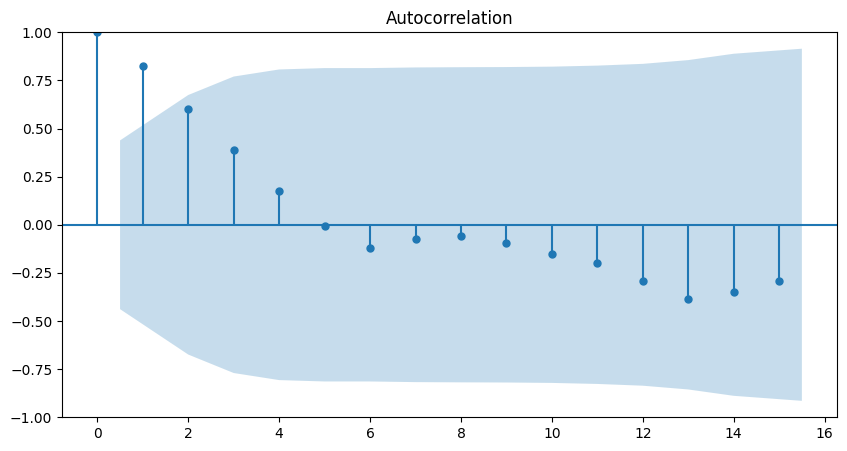

In [16]:
n = 1000 # example number
x = X_test[n]
# plot acf
fig, ax = plt.subplots(figsize=(10, 5))
sm.graphics.tsa.plot_acf(x, lags=15, ax=ax)
plt.show()

# Partial Autocorrelation

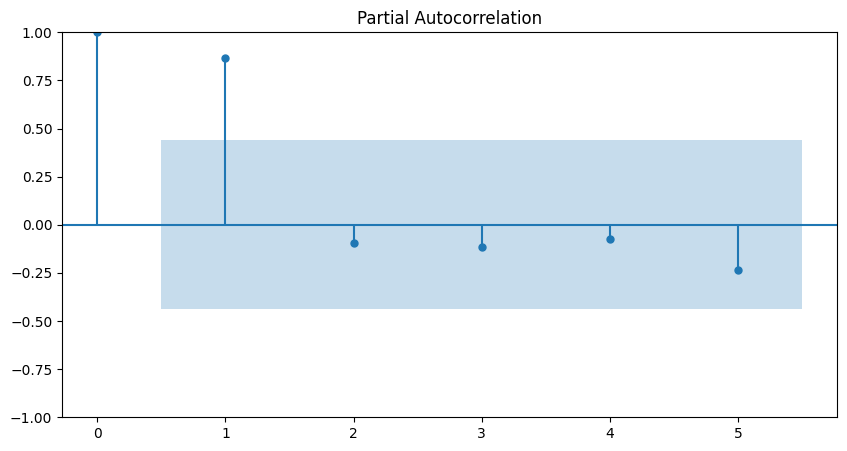

In [11]:
# plot pacf
fig, ax = plt.subplots(figsize=(10, 5))
sm.graphics.tsa.plot_pacf(x, lags=5, ax=ax)
plt.show()